<img style="float:left" width="70%" src="pics/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="15%" src="pics/PythonLogo.svg">
<br style="clear:both;">

<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">Segmentación de imágenes RGB por agrupamiento</h2>

<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: red; line-height: 1.3em; color: white; border-radius: 10px;">Implementación de FCM, y una versión con incorporación de información espacial</h2>

### *Fuzzy C-Means* (FCM) y *Spatial Fuzzy C-Means* (sFCM)
#### Author: Pedro Latorre Carmona
#### Curso: 2025-2026
#### Alumno: Pablo Fernández Gumiel

Versión 1.0

---

En esta práctica, vais a:

1. <span style="color:red">**Implementar FCM desde cero**</span>


2. <span style="color:red">**Implementar una versión de FCM, sobre la que habráis creado en 1), que incluya también información espacial**</span> de una vecindad de ella. Por ejemplo, de $3\times3$, o de $5\times5$.


- La versión espacial de FCM la tenéis explicada en la Sección **III.B** del artículo cuyo **PDF** se os proporciona, también.


- En ambos casos, se ha de considerar el caso de imágenes en color.


- Se os da una imagen en color, sobre la que añadiréis ruido de tipo Gausiano.

suma de las funciones de pertenencia tiene que dar 1 y debemos comprobar que la matriz de pertenencia esta bien, 

Comprobar que FCM funciona, eso se compruab en la matriz de los valores de pertenencia. número de iteraciones 10 unicamente. Asiganamos cada dato a cuyo valor de pertenencia sea mayor. Este paso se hace al final no en cada iteración

Análisis de M y que importancia tiene 

No hay que programar FCM para un numero fijo de grupos

Hay que asignar cada etiqueta a un color para que la imagen salga en diferentes colores por grupos, tambien hay que hacer pruebas y mostrarlas con diferentes numeros de grupos. Es decir no colores medios.

mostarr pruebas condiferentes valores P y Q

---
### Incorporación de ruido *Gausiano*

Sobre la imagen en color que se os da, tendréis que introducir ruido Gausiano, de media cero y una determinada desviación estándar, i. e., $N(0,\sigma)$. 

Lo tendréis que hacer **por cada canal de color**, creando la imagen RGB ruidosa, correspondiente.


---
### Fuzzy C-Means

El procedimiento general de los algoritmos Fuzzy c-Means puede formalizarse en los siguientes pasos:

1. Fijar $c$ y $m$. 

2. Elegir aleatoriamente los centroides.

3. Calcular la matriz de partición difusa inicial $U^{(0)}$ = $[u_{ik}]^{(0)}$, siguiendo la ecuación:

$u_{ik}^{(0)}=\left(\sum \limits _{j=1}^{c}\left[{\frac {d_{ik}^{(0)}}{d_{jk}^{(0)}}}\right]^{\frac {2}{m-1}}\right)^{-1};1\leq k\leq n;1\leq i\leq c$

Una vez inicializado:

4. Calcular: 

    $\mu_{i}^{(t)}=\displaystyle{\frac {\sum \limits _{k=1}^{n}[u_{ik}^{(t)}]^{m}\cdot x_{k}}{\sum \limits _{k=1}^{n}[u_{ik}^{(t)}]^{m}}};1\leq i\leq c$.

5. Actualizar la matriz de partición difusa $U = [u_{ik}]$ con 

    $u_{ik}^{(t+1)}=\left(\sum \limits _{j=1}^{c}\left[{\frac {d_{ik}^{(t)}}{d_{jk}^{(t)}}}\right]^{\frac {2}{m-1}}\right)^{-1};1\leq k\leq n;1\leq i\leq c$

4. Si se alcanzó el criterio de parada, terminar. En caso contrario, regresar al paso 4.

Algunos de los criterios de parada más utilizados son:

- Un número máximo de iteraciones
- Que la variación en la matriz U sea muy pequeña:

$\|U^{k+1}-U^{k}\|<\epsilon$.

---



# Práctica de Segmentación de Imágenes: FCM y sFCM

En este notebook, implementaremos dos algoritmos de *clustering* difuso para segmentar una imagen en color RGB:

1.  **Fuzzy C-Means (FCM)**: El algoritmo estándar de agrupamiento difuso.
2.  **Spatial Fuzzy C-Means (sFCM)**: Una modificación de FCM que incorpora información espacial (de los píxeles vecinos) para ser más robusto frente al ruido.

Ambos algoritmos se implementarán desde cero, basándonos en las fórmulas proporcionadas en el notebook de la práctica y en el artículo PDF adjunto.

### 1. Importación de Librerías y Carga de Imagen

Primero, importamos las librerías necesarias:
* `numpy` para cálculo numérico.
* `cv2` (OpenCV) para leer y manipular la imagen.
* `matplotlib.pyplot` para visualizar las imágenes.
* `scipy.signal.convolve2d` para calcular la función espacial de manera eficiente.

Imagen cargada con dimensiones: (701, 706, 3)


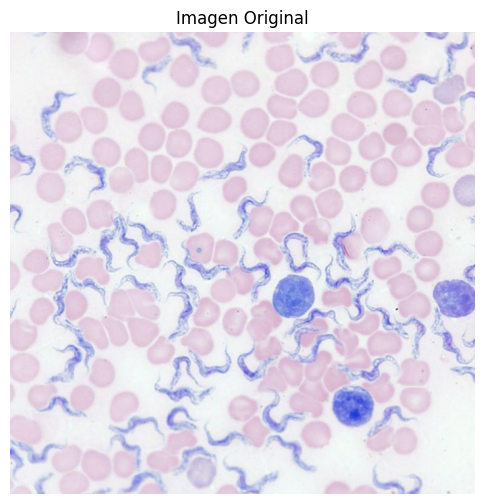

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# --- Configuración de parámetros ---
IMG_PATH = 'ImagenMicroscopiaColor.png'

# Parámetros para el clustering
# C: Número de clusters
C = 4
# M: Parámetro de "fuzziness" controla la borrosidad del clustering.
M = 2.0
# MAX_ITER: Máximo de iteraciones para el bucle del algoritmo.
MAX_ITER = 10
# EPSILON: Criterio de parada. Si el cambio en U es menor, se detiene.
EPSILON = 1e-5

# Parámetros para el ruido
Ruido_MEAN = 0.0
Ruido_SIGMA = 25.0   # Desviación estándar del ruido Gausiano.

# Parámetros para sFCM 
# P: Controla la influencia de la pertenencia original (FCM).
P = 1.0
# Q: Controla la influencia de la información espacial (vecinos).
Q = 1.0

# --- Cargar la imagen ---
# Leemos la imagen. OpenCV la carga en formato BGR.
img_bgr = cv2.imread(IMG_PATH)

# Se convierte a RGB para mostrarla correctamente con matplotlib.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Se normaliza la imagen a [0, 1] para los cálculos.
# Es crucial convertir a float32 ANTES de dividir para mantener la precisión.
img_norm = img_rgb.astype(np.float32) / 255.0

print(f"Imagen cargada con dimensiones: {img_norm.shape}")

# Mostrar la imagen original
plt.figure(figsize=(6, 6))
plt.title("Imagen Original")
plt.imshow(img_norm)
plt.axis('off')
plt.show()

### 2. Incorporación de Ruido Gausiano

Añadimos ruido Gausiano $N(0, \sigma)$ a cada canal de color (R, G, B) de forma independiente.

El ruido se genera con `np.random.normal` y se suma a la imagen normalizada. También nos aseguramos de que los valores resultantes permanezcan en el rango válido [0, 1] usando `np.clip`.

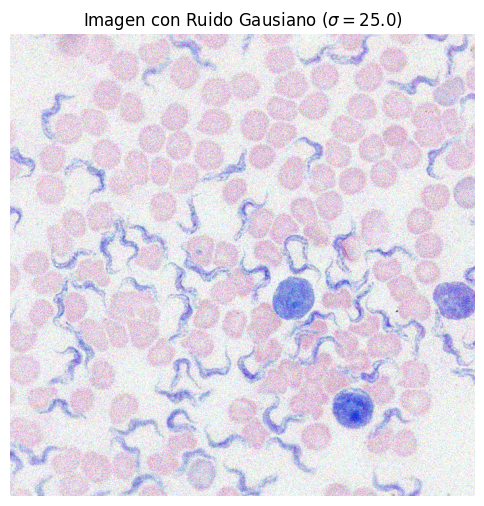

In [21]:
def aplica_ruido_gausiano(imagen, mean=0.0, sigma=1.0):
    """
    Añade ruido Gausiano a cada canal de una imagen.
    
    Args:
        imagen (np.array): Imagen de entrada (H, W, C) normalizada a [0, 1].
        mean (float): Media del ruido.
        sigma (float): Desviación estándar del ruido (en escala 0-255).
    
    Returns:
        np.array: Imagen con ruido, en rango [0, 1].
    """
    # Escalamos sigma al rango [0, 1]
    sigma_norm = sigma / 255.0
    
    # Generamos el ruido Gausiano con las mismas dimensiones que la imagen
    ruido = np.random.normal(mean, sigma_norm, imagen.shape)
    
    # Sumamos el ruido a la imagen
    imagen_ruidosa = imagen + ruido
    
    # Nos aseguramos de que los valores sigan en el rango [0, 1]
    imagen_ruidosa_clip = np.clip(imagen_ruidosa, 0.0, 1.0)
    
    return imagen_ruidosa_clip.astype(np.float32)

# Aplicamos el ruido a nuestra imagen
img_ruido = aplica_ruido_gausiano(img_norm, Ruido_MEAN, Ruido_SIGMA)

# Mostrar la imagen con ruido
plt.figure(figsize=(6, 6))
plt.title(f"Imagen con Ruido Gausiano ($\sigma={Ruido_SIGMA}$)")
plt.imshow(img_ruido)
plt.axis('off')
plt.show()

### 3. Preparación de los Datos para Clustering

Los algoritmos de FCM trabajan sobre un conjunto de **vectores de características**. En nuestro caso, cada píxel es un vector de 3 dimensiones (R, G, B).

Debemos "aplanar" la imagen, convirtiendo nuestra matriz 3D (Alto, Ancho, 3 Canales) en una matriz 2D (Nº Píxeles, 3 Canales).

In [3]:
def preparacion_datos(imagen):
    """
    Convierte una imagen (H, W, C) en una matriz 2D (N_pixels, C).
    
    Args:
        imagen (np.array): Imagen de entrada (H, W, C).
        
    Returns:
        np.array: Datos aplanados (H*W, C).
        tuple: Dimensiones originales (H, W).
    """
    shape_original = imagen.shape
    H, W, C = shape_original
    
    # Reshape: (H, W, C) -> (H * W, C)
    # Cada fila es un píxel, cada columna es una característica (R, G, o B)
    data = imagen.reshape((H * W, C))
    
    return data, (H, W)

# Preparamos los datos de la imagen ruidosa
data_ruido, shape_original = preparacion_datos(img_ruido)
H, W = shape_original
N_PIXELS = data_ruido.shape[0]

print(f"Datos preparados para clustering:")
print(f"  - Píxeles totales (N): {N_PIXELS}")
print(f"  - Características por píxel (Dimensiones): {data_ruido.shape[1]}")

Datos preparados para clustering:
  - Píxeles totales (N): 494906
  - Características por píxel (Dimensiones): 3


### 4. Implementación de Fuzzy C-Means (FCM)

El algoritmo FCM se basa en:

1.  **Inicialización**: Elegimos $c$ centroides $\mu_i$ aleatoriamente.
2.  **Bucle Iterativo**: Repetimos hasta la convergencia (o `MAX_ITER`).
    a.  **Calcular Matriz de Pertenencia $U$**: Para cada píxel $x_k$ y cada clúster $i$, calculamos el grado de pertenencia $u_{ik}$. La fórmula clave es:
        $$u_{ik} = \left( \sum_{j=1}^{c} \left[ \frac{d_{ik}}{d_{jk}} \right]^{\frac{2}{m-1}} \right)^{-1}$$
        Donde $d_{ik} = \|x_k - \mu_i\|^2$ es la distancia Euclídea al cuadrado entre el píxel $k$ y el centroide $i$.

    b.  **Actualizar Centroides $\mu$**: Recalculamos la posición de cada centroide $i$ como la media ponderada (difusa) de todos los píxeles:
        $$\mu_{i} = \frac{\sum_{k=1}^{n} (u_{ik})^m \cdot x_k}{\sum_{k=1}^{n} (u_{ik})^m}$$

3.  **Criterio de Parada**: El bucle termina si el cambio en la matriz de membresía $U$ entre una iteración y la siguiente es menor que `EPSILON`.

In [4]:
def inicializa_centroides(data, C):
    """
    Inicializa C centroides eligiendo C puntos aleatorios de los datos.
    """
    # Obtenemos N índices aleatorios únicos del conjunto de datos
    indices = np.random.choice(data.shape[0], C, replace=False)
    centroides = data[indices, :]
    return centroides.astype(np.float32)


def calcula_pertenencia_fcm(data, centroides, M):
    """
    Calcula la matriz de pertenencia U.
    """
    N_pixeles = data.shape[0]
    N_clusters = centroides.shape[0]
    
    U = np.zeros((N_pixeles, N_clusters), dtype=np.float32)
    
    # 1. Calcular la matriz de distancias (al cuadrado)
    # Uso broadcasting de numpy para eficiencia
    dist_sq = np.sum((data[:, np.newaxis, :] - centroides[np.newaxis, :, :])**2, axis=2)
    
    # Añadimos un valor muy pequeño para evitar división por cero
    # si un píxel coincide exactamente con un centroide
    dist_sq = np.fmax(dist_sq, 1e-9)
    
    # 2. Calcular U usando la fórmula de FCM
    exponente = 2.0 / (M - 1.0)
    
    # (dist_ik / dist_jk) ^ exponent
    # (N, C, 1) / (N, 1, C) -> (N, C, C)
    dist_ratio = dist_sq[:, :, np.newaxis] / dist_sq[:, np.newaxis, :]
    dist_ratio_pow = np.power(dist_ratio, exponente)
    
    # sum_j( ... )
    sum_over_j = np.sum(dist_ratio_pow, axis=2)
    
    # 1 / sum_j( ... )
    U = 1.0 / sum_over_j
    
    return U, dist_sq

def actualiza_centroides_fcm(data, U, M):
    """
    Actualiza los centroides.
    """
    # U^m
    Um = np.power(U, M)
    
    # Denominador: sum_k(U_ik^m) para cada i
    # (N, C) -> (C,)
    denominador = np.sum(Um, axis=0)
    
    # Numerador: sum_k(U_ik^m * x_k) para cada i
    # (N, C)T * (N, D) -> (C, D)
    numerador = np.dot(Um.T, data)
    
    # μ_i = Numerador / Denominador
    # (C, D) / (C, 1)
    nuevos_centroides = numerador / denominador[:, np.newaxis]
    
    return nuevos_centroides.astype(np.float32)

def fuzzy_c_means(data, C, M, max_iter, epsilon):
    """
    Ejecuta el algoritmo FCM completo.
    """
    print(f"Iniciando FCM (C={C}, M={M})...")
    
    # 1. Inicializar centroides
    centroides = inicializa_centroides(data, C)
    
    # 2. Bucle iterativo
    U = np.zeros((data.shape[0], C), dtype=np.float32)
    
    for i in range(max_iter):
        # Guardamos la U anterior para comprobar la convergencia
        U_old = U.copy()
        
        # 3. Calcular nueva matriz U
        U, _ = calcula_pertenencia_fcm(data, centroides, M)
        
        # 4. Actualizar centroides
        centroides = actualiza_centroides_fcm(data, U, M)
        
        # 5. Comprobar criterio de parada
        diff = np.max(np.abs(U - U_old))
        if diff < epsilon:
            print(f"FCM convergió en la iteración {i+1}.")
            break
    else:
        print(f"FCM alcanzó el máximo de iteraciones ({max_iter}).")
        
    return centroides, U

### 5. Ejecución de FCM y Visualización

Ejecuto el algoritmo **FCM estándar** que he implementado.

**Objetivo:**
Aplicar el algoritmo sobre la **imagen con ruido gaussiano**. El objetivo es segmentar la imagen en los $C$ clústeres que hemos definido. Es importante recordar que el FCM estándar toma sus decisiones basándose *únicamente* en el valor de color (RGB) de cada píxel, tratando cada uno de ellos de forma completamente independiente, sin considerar a sus vecinos.

**Expectativa:**
Esperamos que el algoritmo logre una segmentación básica de las estructuras principales de la imagen. Sin embargo, dado que estamos usando la imagen ruidosa y el FCM es muy sensible a este tipo de ruido, prevemos que el resultado estará "contaminado". Probablemente se verá un efecto de "sal y pimienta" (píxeles aislados clasificados incorrectamente) en las regiones segmentadas.

Para visualizar el resultado, "defuzzificamos" la imagen: asignamos a cada píxel el clúster (color) para el cual tiene el mayor grado de membresía (el $\mu_i$ correspondiente).

Iniciando FCM (C=4, M=2.0)...
FCM alcanzó el máximo de iteraciones (10).


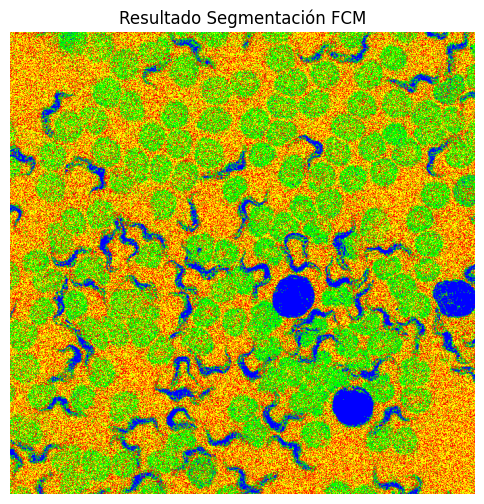

In [5]:
def defuzzify_image(data, centroides, U, shape_original):
    """
    Crea la imagen segmentada asignando cada píxel al clúster
    con la membresía más alta (np.argmax) Y ASIGNA UN COLOR FIJO
    A CADA ETIQUETA.
    """
    H, W = shape_original
    
    # 1. Encontrar el índice del clúster con max(U) para cada píxel
    etiquetas = np.argmax(U, axis=1)
    
    n_clusters = centroides.shape[0] # Obtenemos el número de clústeres

    fixed_colors = np.array([
        # --- Colores ---
        [255, 255, 0],  # Color para la etiqueta 0 (Amarillo)
        [255, 0, 0],    # Color para la etiqueta 1 (Rojo)
        [0, 0, 255],    # Color para la etiqueta 2 (Azul)
        [0, 128, 0],    # Color para la etiqueta 3 (Verde)
        [255, 0, 255],  # Color para la etiqueta 4 (Magenta)
        [0, 255, 255],  # Color para la etiqueta 5 (Cyan)
        [255, 128, 0],  # Color para la etiqueta 6 (Naranja)
        [128, 0, 128],  # Color para la etiqueta 7 (Morado)
        [255, 255, 255],# Color para la etiqueta 8 (Blanco)
        [0, 0, 0],      # Color para la etiqueta 9 (Negro)
            
        ], dtype=np.float32) # Usamos float32 para ser consistentes

    # Comprobamos si el número de colores que hemos definido
    # es MENOR que el número de clústeres que ha encontrado el algoritmo.
    if len(fixed_colors) < n_clusters:
        print(f"¡Advertencia! El número de clústeres ({n_clusters}) es MAYOR que el número de colores fijos ({len(fixed_colors)}).")
        # Si no coinciden, usamos los centroides originales para evitar un error
        datos_segmentados = centroides[etiquetas]
    else:
        # 3. Crear la nueva imagen usando el MAPA DE COLORES FIJOS
        #    Usamos [etiquetas] para "elegir" el color de la lista
        datos_segmentados = fixed_colors[etiquetas]
        
    # 4. Reshape de vuelta a la forma de imagen (H, W, 3)
    imagen_segmentada = datos_segmentados.reshape((H, W, 3))
    
    return imagen_segmentada.astype(np.float32)

# --- Ejecutar FCM ---
fcm_centroides, fcm_U = fuzzy_c_means(data_ruido, C, M, MAX_ITER, EPSILON)

# --- Generar Imagen Segmentada ---
fcm_imagen_segmentada = defuzzify_image(data_ruido, fcm_centroides, fcm_U, shape_original)

# Mostrar el resultado de FCM
plt.figure(figsize=(6, 6))
plt.title("Resultado Segmentación FCM")
# Hacemos clip por si los centroides cayeron ligeramente fuera de [0, 1]
plt.imshow(np.clip(fcm_imagen_segmentada, 0, 1))
plt.axis('off')
plt.show()

### 6. Implementación de Spatial FCM (sFCM) desde Cero

Modificamos FCM para incluir información espacial.

El algoritmo es un proceso de dos pasos *dentro* de cada iteración:

1.  **Paso 1 (FCM Estándar)**: Calculamos la matriz de membresía $U$ basada en la intensidad/color, exactamente igual que en FCM (la llamaremos $U_{fcm}$).

2.  **Paso 2 (Información Espacial)**:
    a.  Se define una **función espacial $h_{ij}$**  que suma las membresías de los *vecinos* de un píxel $j$ al clúster $i$:
        $$h_{ij} = \sum_{k \in NB(x_j)} U_{ik}$$
        Donde $NB(x_j)$ es una vecindad (ej. $3 \times 3$) alrededor del píxel $j$. Usaremos la $U_{fcm}$ calculada en el Paso 1 para esto.

    b.  La membresía $U$ se actualiza incorporando $h$ :
        $$U'_{ij} = \frac{(U_{fcm})_{ij}^{p} \cdot h_{ij}^{q}}{\sum_{k=1}^{c} (U_{fcm})_{kj}^{p} \cdot h_{kj}^{q}}$$
        Donde $p$ y $q$ controlan la importancia de la intensidad ($U_{fcm}$) y el espacio ($h$).

3.  **Actualización de Centroides**: Usamos esta nueva $U'_{ij}$ (la membresía espacialmente ponderada) para calcular los nuevos centroides, igual que en el FCM estándar.

In [13]:
def calculo_funcion_espacial(U, H, W, N_clusters):
    """
    Calcula la función espacial h (suma de pertenencias en la vecindad)
    para cada píxel 'k' y cada clúster 'i', SIN usar convolve2d.
    
    Esta función reemplaza a la versión con convolve2d.
    
    Args:
        U (np.array): Matriz de pertenencia (N, C), donde N = H * W
        H (int): Número de filas de la imagen original.
        W (int): Número de columnas de la imagen original.
        N_clusters (int): Número de clústeres (C).
        
    Returns:
        np.array: Matriz H (N, C) con la suma espacial.
    """
    
    # Reformateamos U a su forma 2D (imagen) para acceder por (fila, col)
    # El shape es (H, W, C)
    try:
        U_2d = U.reshape((H, W, N_clusters))
    except ValueError:
        # Si N_clusters no coincide por algún motivo, usamos el de U
        N_clusters = U.shape[1]
        U_2d = U.reshape((H, W, N_clusters))

    # Creamos la matriz H de salida, también en formato 2D
    H_2d = np.zeros_like(U_2d, dtype=np.float32)

    # --- Reemplazo de convolve2d ---
    
    # 1. Iteramos por CADA píxel (fila, columna)
    for r in range(H):
        for c in range(W):
            
            # 2. Para este píxel (r, c), iteramos por cada clúster 'i'
            for i_cluster in range(N_clusters):
                
                suma_vecindad = 0.0
                
                # 3. Iteramos por su vecindad de 3x3 (de -1 a +1)
                for i_vecino in range(-1, 2): 
                    for j_vecino in range(-1, 2):
                        
                        # Calculamos las coordenadas del vecino
                        vecino_r = r + i_vecino
                        vecino_c = c + j_vecino
                        
                        # 4. Comprobamos que el vecino está DENTRO de la imagen
                        if (0 <= vecino_r < H) and (0 <= vecino_c < W):
                            # Si está dentro, sumamos su pertenencia al clúster 'i'
                            suma_vecindad += U_2d[vecino_r, vecino_c, i_cluster]
                        # else:
                            # Si está fuera, no suma nada (equivale a 'boundary=fill')
                            pass
                
                # Asignamos la suma total de la vecindad al píxel (r, c)
                H_2d[r, c, i_cluster] = suma_vecindad
    
    # --- Fin del reemplazo ---

    # Devolvemos H a su formato "plano" (N, C)
    N_pixels = H * W
    h = H_2d.reshape((N_pixels, N_clusters))
    
    return h.astype(np.float32)


def spatial_fuzzy_c_means(data, C, M, P, Q, H, W, max_iter, epsilon):
    """
    Ejecuta el algoritmo sFCM completo (FCM + Info Espacial).
    """
    print(f"Iniciando sFCM (C={C}, M={M}, P={P}, Q={Q})...")
    
    N_pixels = data.shape[0]
    
    # 1. Inicializar centroides
    centroides = inicializa_centroides(data, C)
    
    # 2. Bucle iterativo
    U_spatial = np.zeros((N_pixels, C), dtype=np.float32)
    
    for i in range(max_iter):
        U_spatial_antiguo = U_spatial.copy()
        
        # --- PASO 1 (FCM Estándar) ---
        # Calcular la membresía U_fcm basada solo en la intensidad/color
        U_fcm, _ = calcula_pertenencia_fcm(data, centroides, M)
        
        # --- PASO 2 (Información Espacial) ---
        # a. Calcular la función espacial h
        # Usamos U_fcm como entrada para h
        h = calculo_funcion_espacial(U_fcm, H, W, C)
        
        # b. Calcular la nueva membresía U_spatial
        # Numerador: (U_fcm)^p * h^q
        numerador_spatial = np.power(U_fcm, P) * np.power(h, Q)
        
        # Denominador: sum_k( (U_fcm_k)^p * h_k^q )
        # (N, C) -> (N, 1)
        denominador_spatial = np.sum(numerador_spatial, axis=1, keepdims=True)
        
        # Evitar división por cero
        denominador_spatial = np.fmax(denominador_spatial, 1e-9)
        
        U_spatial = numerador_spatial / denominador_spatial
        
        # 3. Actualizar Centroides
        centroides = actualiza_centroides_fcm(data, U_spatial, M)
        
        # 4. Comprobar criterio de parada
        diff = np.max(np.abs(U_spatial - U_spatial_antiguo))
        if diff < epsilon:
            print(f"sFCM convergió en la iteración {i+1}.")
            break
    else:
        print(f"sFCM alcanzó el máximo de iteraciones ({max_iter}).")
            
    return centroides, U_spatial

### 7. Ejecución de Spatial FCM (sFCM)

Ahora ejecutamos la implementación del algoritmo **sFCM (Spatial Fuzzy C-Means)**. Su principal objetivo es incorporar **información espacial** para mejorar la robustez del clustering, especialmente frente al ruido.

**¿Por qué es importante?**
* El FCM estándar trata cada píxel de forma independiente. Esto lo hace muy **sensible al ruido**, ya que un píxel ruidoso (un punto blanco en una zona negra, por ejemplo) será clasificado incorrectamente, independientemente de lo que tenga alrededor.
* El sFCM, al considerar los vecinos (a través del término espacial $h_{ij}$ que calculamos con una convolución), asume que un píxel probablemente pertenece al mismo clúster que los píxeles que lo rodean.

**Expectativa:**
Aplicaremos el algoritmo sFCM sobre la **misma imagen con ruido** que usamos para el FCM. Esperamos que la segmentación resultante sea **más robusta** y visualmente más coherente. El resultado debería ser una imagen con regiones más homogéneas y con una reducción del efecto "sal y pimienta" que probablemente produce el FCM estándar.

Se utilizarán los mismos parámetros `C` y `M`, además de los nuevos parámetros `P_sFCM` y `Q_sFCM` que ponderan la influencia del componente de pertenencia original y el componente espacial, respectivamente.

Iniciando sFCM (C=4, M=2.0, P=1.0, Q=1.0)...
sFCM alcanzó el máximo de iteraciones (10).


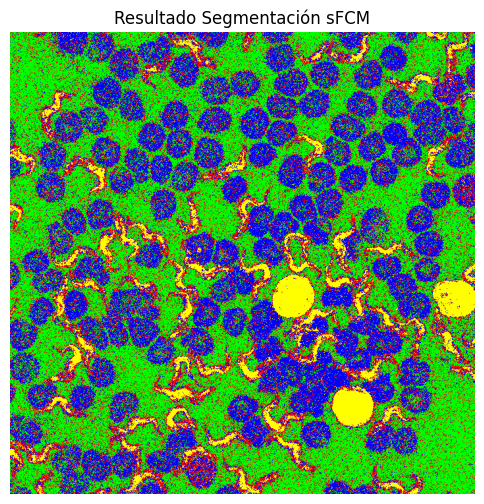

In [14]:
# --- Ejecutar sFCM ---
sfcm_centroides, sfcm_U = spatial_fuzzy_c_means(
    data_ruido, C, M, P, Q, H, W, MAX_ITER, EPSILON
)

# --- Generar Imagen Segmentada ---
sfcm_imagen_segmentada = defuzzify_image(data_ruido, sfcm_centroides, sfcm_U, shape_original)

# Resultado 

plt.figure(figsize=(6, 6))
plt.title("Resultado Segmentación sFCM")
# Hacemos clip por si los centroides cayeron ligeramente fuera de [0, 1]
plt.imshow(np.clip(sfcm_imagen_segmentada, 0, 1))
plt.axis('off')
plt.show()


### 8. Comprobación y Comparación Final

#### Verificación de la Matrices de Pertenencia

Una de las propiedades matemáticas fundamentales del algoritmo **Fuzzy C-Means (FCM)** es la restricción de que la suma de los grados de pertenencia de *un solo punto* (en nuestro caso, un píxel) a *todos* los clústeres debe ser exactamente **1**.

$$
\sum_{j=1}^{C} u_{ij} = 1, \quad \forall i=1, \dots, N
$$

Donde:
* $N$ es el número total de píxeles.
* $C$ es el número de clústeres.
* $u_{ij}$ es el grado de pertenencia del píxel $i$ al clúster $j$.

**¿Por qué esta comprobación?**

1.  **Validar la implementación:** Esta celda comprueba que la función `actualizar_U_fcm` (y `actualizar_U_sfcm`) es numéricamente correcta. Si las sumas no dieran 1 (o un valor extremadamente cercano, debido a la precisión de los `float`), significaría que hay un error en la implementación de la fórmula de actualización.
2.  **Confirmar la teoría:** Demuestra que el algoritmo está funcionando como se espera. La pertenencia total de un píxel no se "pierde" ni se "crea"; simplemente se *distribuye* de forma difusa (fuzzy) entre los $C$ clústeres. Un píxel en el borde de dos clústeres podría tener `[0.1, 0.45, 0.45, 0.0]`, y un píxel en el centro de uno tendría `[0.97, 0.01, 0.01, 0.01]`. En ambos casos, la suma es 1.

Esta comprobación da la confianza de que los valores de pertenencia son correctos y que por tanto el proceso ha funcionado de manera correcta

In [92]:
# Genero la función que va a verificar que las matrices de pertenencia son correctas

def verificar_matriz_U(nombre_matriz, U):
    """Función para verificar una matriz de pertenencia."""

    # 1. Sumar las pertenencias para cada píxel (a lo largo del eje de clústeres)
    sumas_pertenencia = np.sum(U, axis=1)
        
    # 2. Comprobar si *todas* las sumas son 1.0 (con tolerancia)
    todas_suman_uno = np.allclose(sumas_pertenencia, 1.0)
        
    print(f"\nVerificando '{nombre_matriz}' (forma: {U.shape}):")
        
    if todas_suman_uno:
        print("  ¡VERIFICACIÓN CORRECTA! Todas las sumas de píxeles son ~1.0.")
    else:
        print("  ¡ERROR! No todas las sumas de píxeles son 1.0.")
        
    # 3. Mostrar los valores extremos de la suma
    print(f"      Suma MÍNIMA: {round(np.min(sumas_pertenencia),7)}")
    print(f"      Suma MÁXIMA: {round(np.max(sumas_pertenencia),7)}")

# Verificar U_fcm
verificar_matriz_U('U_fcm', fcm_U)

# Verificar U_sfcm
verificar_matriz_U('U_sfcm', sfcm_U)


Verificando 'U_fcm' (forma: (494906, 4)):
  ¡VERIFICACIÓN CORRECTA! Todas las sumas de píxeles son ~1.0.
      Suma MÍNIMA: 0.9999998211860657
      Suma MÁXIMA: 1.000000238418579

Verificando 'U_sfcm' (forma: (494906, 4)):
  ¡VERIFICACIÓN CORRECTA! Todas las sumas de píxeles son ~1.0.
      Suma MÍNIMA: 0.9999998211860657
      Suma MÁXIMA: 1.000000238418579


Finalmente, comparamos los tres resultados: la imagen ruidosa original, la segmentación con FCM estándar y la segmentación con sFCM.

Esperamos que sFCM produzca regiones más homogéneas y elimine gran parte del ruido (píxeles aislados mal clasificados) que FCM no pudo corregir.

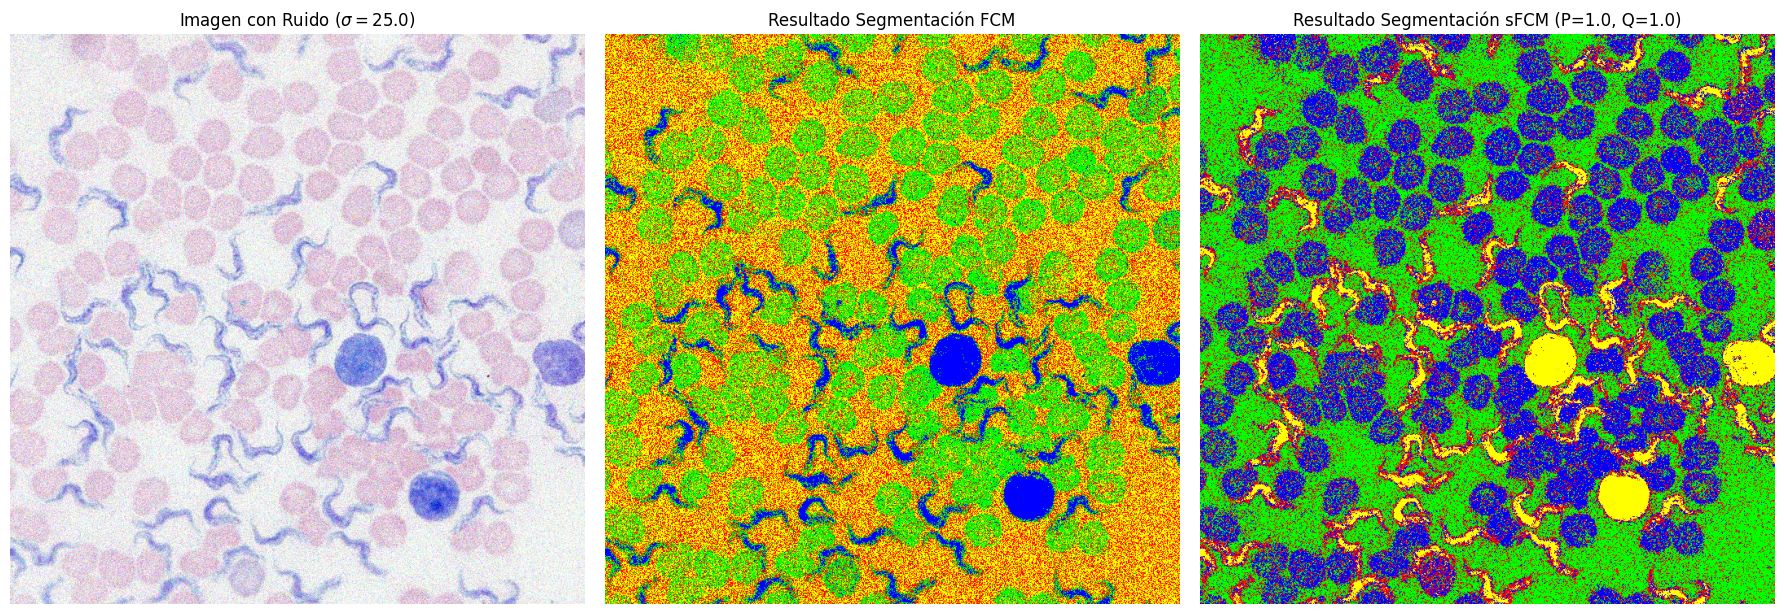

In [15]:
# --- Comparación Final ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Imagen Ruidosa
axes[0].imshow(img_ruido)
axes[0].set_title(f"Imagen con Ruido ($\sigma={Ruido_SIGMA}$)")
axes[0].axis('off')

# Resultado FCM
axes[1].imshow(np.clip(fcm_imagen_segmentada, 0, 1))
axes[1].set_title("Resultado Segmentación FCM")
axes[1].axis('off')

# Resultado sFCM
axes[2].imshow(np.clip(sfcm_imagen_segmentada, 0, 1))
axes[2].set_title(f"Resultado Segmentación sFCM (P={P}, Q={Q})")
axes[2].axis('off')

plt.tight_layout()
plt.show()


Tras la implementación de los algoritmos y la visualización de los resultados, podemos extraer conclusiones claras sobre el rendimiento de ambos métodos de clustering.

La comparación visual de las imágenes segmentadas es la prueba más evidente:

1.  **Rendimiento de FCM Estándar:**
    * Al aplicar FCM sobre la imagen con ruido gaussiano, el resultado es **sensible al ruido**.
    * La imagen segmentada presenta una gran cantidad de píxeles clasificados incorrectamente, lo que se conoce como **efecto "sal y pimienta"**.
    * Esto ocurre porque el FCM estándar toma sus decisiones basándose *únicamente* en el valor de color (RGB) de cada píxel, tratándolo de forma aislada. Un píxel ruidoso, aunque esté en medio de una región homogénea, será clasificado incorrectamente si su color se aleja lo suficiente del centroide de esa región.

2.  **Rendimiento de sFCM (Spatial FCM):**
    * Al aplicar sFCM sobre la **misma imagen ruidosa**, el resultado es **superior** y mucho más robusto.
    * El algoritmo logra **eliminar parte del ruido** de la segmentación, produciendo regiones mucho más homogéneas y visualmente coherentes.
    * Esto se debe a la **incorporación de la información espacial** (el término $h_{ij}$). La pertenencia de un píxel ya no depende solo de su color, sino también de las pertenencias de sus vecinos. En la práctica, esto actúa como un "filtro" que corrige las clasificaciones erróneas de píxeles ruidosos aislados, forzándolos a adoptar la clasificación de su vecindario.